## Simulation 1

In [1]:
%matplotlib widget

# Environment Setup & Training

In [ ]:
# ----- DEPENDENCIES -----

import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rich
from pathlib import Path
from floris.flow_visualization import visualize_cut_plane
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.noise import NormalActionNoise
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from floris import FlorisModel
import torch

# ----- ENV SETUP -----

class FlorisEnv(gym.Env):
    def __init__(self, config_path):
        super(FlorisEnv, self).__init__()
        self.fmodel = FlorisModel(config_path)
        
        # Setup Farm Layout
        D = 126.0
        self.x_layout = [0, 0, 6 * D, 6 * D]
        self.y_layout = [0, 3 * D, 0, 3 * D]
        self.fmodel.set(layout_x=self.x_layout, layout_y=self.y_layout)
        self.n_turbines = len(self.x_layout)
        
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.n_turbines,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([270.0, 8.0, 0.05]), 
            high=np.array([280.0, 11.0, 0.20]), 
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_wd = np.random.uniform(270.0, 280.0)
        self.current_ws = np.random.uniform(8.0, 11.0)
        self.current_ti = np.random.uniform(0.05, 0.20)
        return np.array([self.current_wd, self.current_ws, self.current_ti], dtype=np.float32), {}

    def step(self, action):
        yaw_angles = action * 25.0
        
        # Baseline
        self.fmodel.set(wind_directions=[self.current_wd], wind_speeds=[self.current_ws], 
                        turbulence_intensities=[self.current_ti], yaw_angles=np.zeros((1, self.n_turbines)))
        self.fmodel.run()
        baseline_mw = np.sum(self.fmodel.get_turbine_powers()) / 1e6

        # Control
        self.fmodel.set(yaw_angles=np.array([yaw_angles]))
        self.fmodel.run()
        rl_mw = np.sum(self.fmodel.get_turbine_powers()) / 1e6
        
        gain_pct = 100 * (rl_mw - baseline_mw) / baseline_mw
        obs = np.array([self.current_wd, self.current_ws, self.current_ti], dtype=np.float32)
        
        return obs, rl_mw, True, False, {"baseline_kw": baseline_mw * 1000, "power_kw": rl_mw * 1000, "gain_pct": gain_pct}

# Initialize Env (Update this path to your actual yaml file)
CONFIG_PATH = "data_generation/farm_types/gch.yaml" 
env = FlorisEnv(CONFIG_PATH)

# ----- TRAINING -----
def run_training(algo="PPO", steps=10000):    
    log_path = "./tensorboard_logs_test_controllers/"
    if algo == "PPO":
        model = PPO("MlpPolicy", env, verbose=0, 
                    tensorboard_log=log_path) 
    else:
        n_actions = env.action_space.shape[-1]
        noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        model = DDPG("MlpPolicy", env, action_noise=noise, verbose=0, 
                     tensorboard_log=log_path) 
    
    print(f" Training {algo} and logging to {log_path}...")
    
    model.learn(
        total_timesteps=steps, 
        tb_log_name=f"{algo}_run", # This creates a subfolder like PPO_run_1
        progress_bar=False,
    )
    return model

ppo_model = run_training("PPO", 20000)
ddpg_model = run_training("DDPG", 20000)

/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


 Training PPO and logging to ./tensorboard_logs_test_controllers/...


/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/floris/core/flow_field.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  * np.power(


 Training DDPG and logging to ./tensorboard_logs_test_controllers/...


In [4]:

from stable_baselines3 import SAC
sac_model = run_training("SAC", 20000)

 Training SAC and logging to ./tensorboard_logs_test_controllers/...


/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/floris/core/flow_field.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  * np.power(


# Evaluate

Testing 3 models over 50 episodes...
Done! df_eval created.


ValueError: Could not interpret value `PPO_Sacrifice` for `x`. An entry with this name does not appear in `data`.

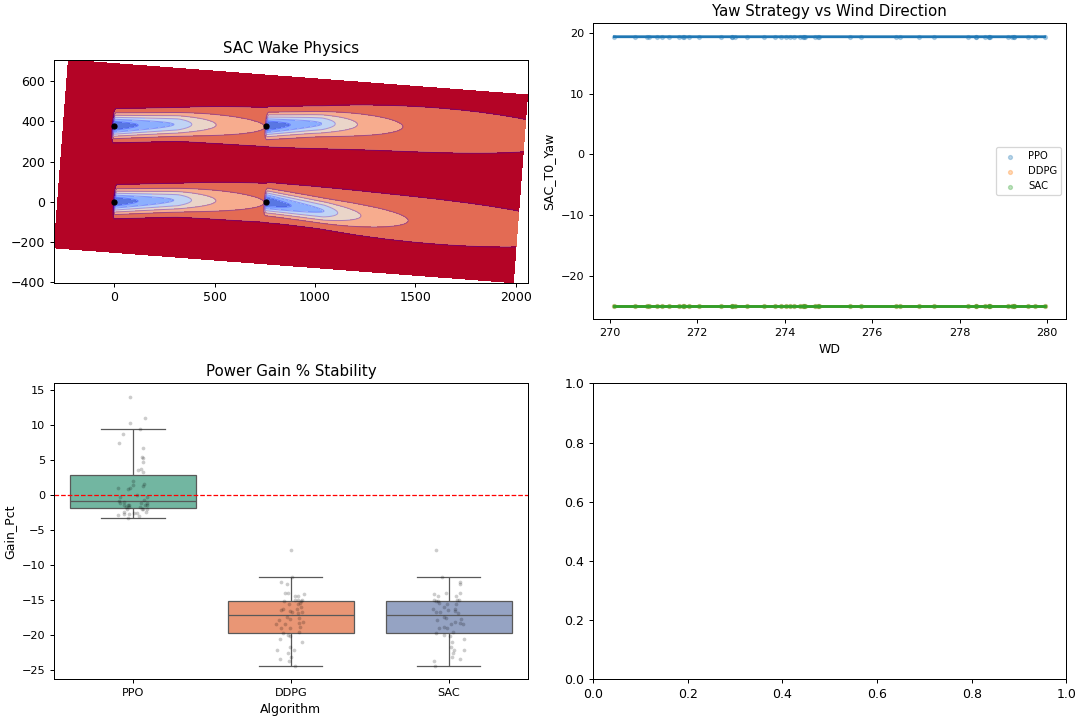

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

def run_comprehensive_eval(models, n_episodes=50):
    results = []
    print(f"Testing {len(models)} models over {n_episodes} episodes...")
    
    for i in range(n_episodes):
        # 1. Reset env to get a new random wind condition
        obs, _ = env.reset()
        wd, ws, ti = obs
        
        # 2. Baseline Run (All Yaw = 0)
        env.fmodel.set(wind_directions=[wd], wind_speeds=[ws], 
                        turbulence_intensities=[ti], yaw_angles=np.zeros((1, env.n_turbines)))
        env.fmodel.run()
        base_powers = env.fmodel.get_turbine_powers().flatten() / 1e3 # Convert to kW
        base_total = np.sum(base_powers)
        
        # Initialize data dict for this episode
        data = {
            "Episode": i, "WD": wd, "WS": ws, "TI": ti,
            "Base_Total_kW": base_total,
            "Base_T0_kW": base_powers[0]
        }
        
        # 3. Test each RL Agent on this EXACT same wind condition
        for name, model in models.items():
            # Force observation to float32 to avoid the TypeError
            action, _ = model.predict(obs.astype(np.float32), deterministic=True)
            yaw_deg = action * 25.0
            
            env.fmodel.set(yaw_angles=np.array([yaw_deg]))
            env.fmodel.run()
            rl_powers = env.fmodel.get_turbine_powers().flatten() / 1e3 # kW
            rl_total = np.sum(rl_powers)
            
            # Record Performance
            data[f"{name}_Total_kW"] = rl_total
            data[f"{name}_Gain%"] = 100 * (rl_total - base_total) / base_total
            data[f"{name}_T0_Yaw"] = yaw_deg[0] 
            data[f"{name}_T0_kW"] = rl_powers[0] 
            
        results.append(data)
    
    print("Done! df_eval created.")
    return pd.DataFrame(results)

# --- EXECUTE THIS TO CREATE df_eval ---
models_to_test = {"PPO": ppo_model, "DDPG": ddpg_model, "SAC": sac_model}
df_eval = run_comprehensive_eval(models_to_test, n_episodes=50)

# Suppress the noisy NumPy/FLORIS warnings for a clean report
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Prepare Data ---
model_names = ["PPO", "DDPG", "SAC"]
df_melted = df_eval.melt(
    id_vars=['WD', 'WS'], 
    value_vars=[f"{n}_Gain%" for n in model_names],
    var_name='Algorithm', value_name='Gain_Pct'
)
df_melted['Algorithm'] = df_melted['Algorithm'].str.replace('_Gain%', '')

# --- 1. Force Column Creation to avoid ValueError ---
for name in ["PPO", "DDPG", "SAC"]:
    sac_col = f"{name}_Sacrifice"
    # Calculate sacrifice: (Baseline Power - RL Power) / Baseline Total
    # This represents how much "sacrifice" the first turbine made.
    df_eval[sac_col] = 100 * (df_eval['Base_T0_kW'] - df_eval[f'{name}_T0_kW']) / df_eval['Base_Total_kW']

# --- 2. Compact Setup for Smaller Screens ---
fig = plt.figure(figsize=(11, 7), constrained_layout=True, dpi=100) 
gs = fig.add_gridspec(2, 2)

# Plot 1: Wake Physics
ax1 = fig.add_subplot(gs[0, 0])
test_obs = df_eval.iloc[0][['WD', 'WS', 'TI']].values.astype(np.float32)
action, _ = sac_model.predict(test_obs, deterministic=True)
env.fmodel.set(wind_directions=[test_obs[0]], wind_speeds=[test_obs[1]], 
                turbulence_intensities=[test_obs[2]], yaw_angles=np.array([action * 25.0]))
env.fmodel.run()
hor_plane = env.fmodel.calculate_horizontal_plane(height=90.0)
from floris.flow_visualization import visualize_cut_plane
visualize_cut_plane(hor_plane, ax=ax1, title="Wake Physics (SAC)")
ax1.plot(env.x_layout, env.y_layout, "ko", markersize=3)

# Plot 2: Control Strategy
ax2 = fig.add_subplot(gs[0, 1])
for name in ["PPO", "DDPG", "SAC"]:
    sns.regplot(data=df_eval, x='WD', y=f'{name}_T0_Yaw', label=name, 
                scatter_kws={'alpha':0.3, 's':8}, ax=ax2)
ax2.set_title("Strategy vs Wind Direction", fontsize=10)
ax2.legend(fontsize=7, loc='upper left')

# Plot 3: Statistical Boxplot
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_melted, x='Algorithm', y='Gain_Pct', hue='Algorithm', 
            palette='Set2', ax=ax3, showfliers=False, legend=False)
sns.stripplot(data=df_melted, x='Algorithm', y='Gain_Pct', color='black', alpha=0.2, size=2, ax=ax3)
ax3.axhline(0, color='red', linestyle='--', linewidth=0.8)
ax3.set_title("Power Gain % Stability", fontsize=10)

# Plot 4: Sacrifice vs Gain (The Pareto Front)
ax4 = fig.add_subplot(gs[1, 1])
for name in ["PPO", "DDPG", "SAC"]:
    sns.scatterplot(data=df_eval, x=f"{name}_Sacrifice", y=f'{name}_Gain%', 
                    label=name, alpha=0.5, s=15, ax=ax4)
ax4.set_title("Sacrifice vs Farm Gain", fontsize=10)
ax4.set_xlabel("T0 Sacrifice (%)", fontsize=8)
ax4.set_ylabel("Farm Gain (%)", fontsize=8)
ax4.legend(fontsize=7)

plt.show()

next steps: validation script